# **Week 12: Basics of Machine learning: predicting ENSO using Nino 3.4 index**

This jupyter notebook aims to explain the basic concept of machine learning using ENSO prediction as an example. Concepts include:
1. data wrangling (part 1)
2. sklearn framework (part 1)
3. overfitting/underfitting, regularization (part 1)
4. random forest (part 2)
5. physical explainability, shapeley value (part 2)
6. simple neural network (part 3)
7. classification v.s. regression (part 3)

# **Reference:**
### [1] Climate Change AI Summer School: Day 3 Climate Science Tutorial: Seasonal Forecasting by Ankur Mahesh (UC Berkeley)
See [here](https://colab.research.google.com/drive/1eLEYFK3Mrae_nu1SzAjg7Sdf40bWnKTg#scrollTo=12Pzw4pM1Fhs&forceEdit=true&sandboxMode=true) for the original notebook for CCAI tutorial.

This material is modified by Dr.Yi-Chi Wang and used for learning in IPCS class only.

### Machine Learning Fundamentals

As this notebook only introduces practical framework of using machine learning for prediction, the CCAI tutorial strongly suggest to refer
*  Chapters from Professor Jonathan Shewchuk's excellent lecture notes from CS189 (UC Berkeley's Machine Learning class)
**   Professor Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)

* Course notes developed by TAs including Garrett Thomas and Soroush Nasiriany
, which provides a rigorous mathematical basis of the foundations of machine learning. If you are interested in going deeper into machine learning, I strongly recommend reading these two resources.
**   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

## Introduction : ENSO

See [here](https://www.climate.gov/enso) for some introductory information for ENSO.

El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we will issue ENSO forecasts using machine learning, which uses statistical optimization to issue forecasts.






## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.




### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

### Val Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set: 

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).


Follow the previous class, please write a function to read in netcdf files and calculate.

In [ ]:
# download ENSO index file from Yi-Chi's google drive.
#https://drive.google.com/file/d/1bQLw7S3OwuvTKHOjnrYEanWSAHlu8sP1/view?usp=share_link
!gdown 1bQLw7S3OwuvTKHOjnrYEanWSAHlu8sP1

Downloading...
From: https://drive.google.com/uc?id=1bQLw7S3OwuvTKHOjnrYEanWSAHlu8sP1
To: /content/ENSOindex.oni.1960-2020.nc
100% 23.0k/23.0k [00:00<00:00, 58.8MB/s]


In [ ]:
#Download sst observations from 1880 to 2018
# https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From: https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:06<00:00, 62.4MB/s]


In [ ]:
# check if ENSO index file is loaded
filename ='ENSOindex.oni.1960-2020.nc'
ds_sst = xr.open_dataset(filename)
ds_sst.head()

<xarray.Dataset>
Dimensions:  (time: 5)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 1960-05-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the netcdf file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  #read SST
  filename ='ENSOindex.oni.1960-2020.nc'
  ds_sst = xr.open_dataset(filename)
  ds_sst
  ds_sst = ds_sst.sel(time=slice('1960', '2020'))
  ds_sst.load()
  ts_nino34 = ds_sst["sst"].to_series()
  return ts_nino34


In [ ]:
#!pip install netCDF4

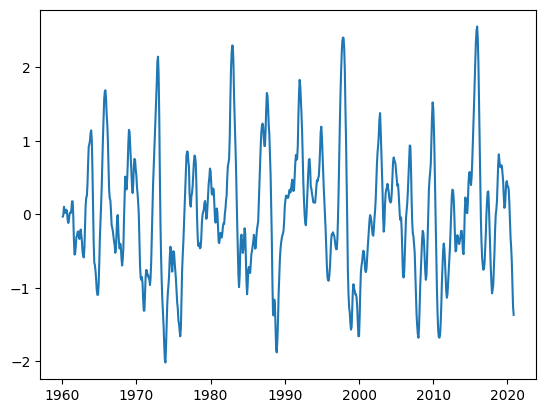

In [ ]:
# This cell tests the reading of 
nino34 = load_enso_indices()
#nino34
#nino34 = nino34.to_series()
#ts_nino34 = nino34["sst"].to_series()

plt.figure()
plt.plot(nino34)

In [ ]:
def assemble_basic_predictors_predictands(start_date, end_date, lead_time, 
                                    n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y




In [ ]:
def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


# Baseline Machine Learning Model


The baseline ML model will be linear regression.



RMSE: 0.18


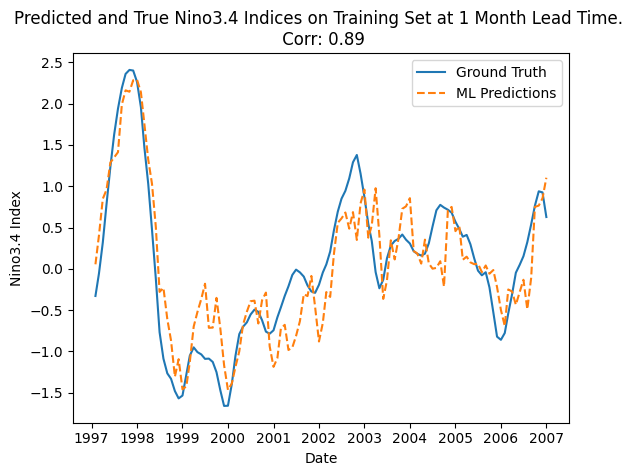

In [ ]:

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Metrics

The metrics for evaluating this ML model are 

*  Pearson correlation
*   RMSE

The above code snippet includes examples of calculating them.

## Key Terms



Some terms:
*   predictor     : the input to a machine learning model: a certain number of months (that you define) of gridded temperature)
*   predictand    : the true value the model is trying to predict (i.e. the true Niño3.4 index)
*   prediction    : the output of the machine learning model




##Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the label). In our case,  
*   predictors : anomalized global temperature
*   predictand : the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time

Let's call our predictors $X$, and our predictand $y$.  Our goal is to find a model describing the relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index. The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set (X_train, y_train) and a test set (X_test, y_test).


*   During training, the ML model is shown the predictors X_train and their associated predictands y_train.  The ML model uses optimization to learn a function: given X_train, the function outputs the y_train as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. y_test) with X_test as input. 
** When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
**   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***Question***: In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




In the next code cell, let's study overfitting in the following task: training a machine learning model to forecast El Niño.  El Niño is a cycle of warm and cold temperatures in the equatorial Pacific Ocean that has broad implications for seasonal weather.

The code cell below demonstrates overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


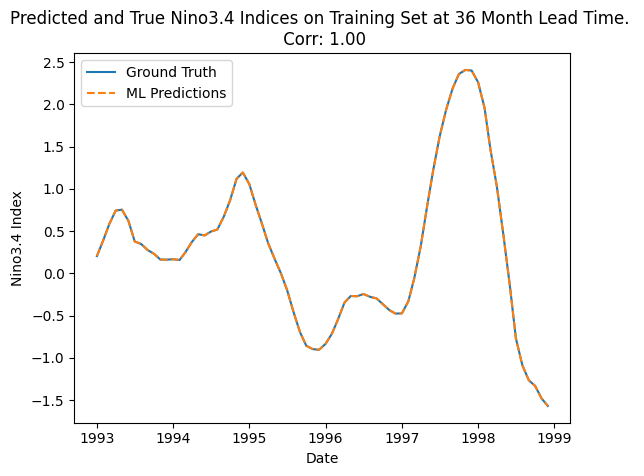

In [ ]:
#Load in the predictors
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


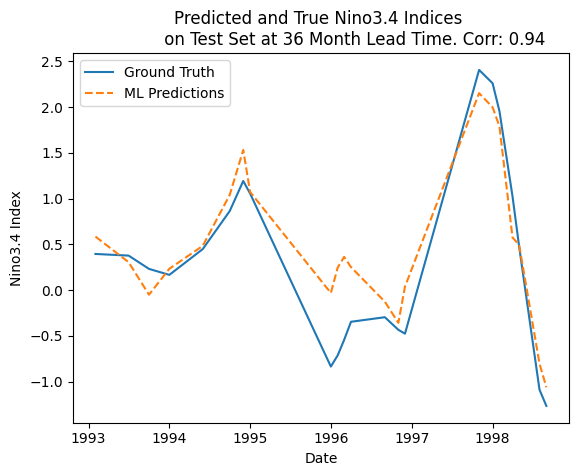

In [ ]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

What happened above? Did we just develop a 36-month ahead forecast that has 0.81 correlation on unseen data??

**Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.**  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**Take-home exercise I:** Will performance on a true, uncorrelated test set be better or worse than performance on the biased dataset (when correlation was 0.81)?

In [ ]:
"""Take home exercise: write code to explore the above question"""


'Take home exercise: write code to explore the above polling question'

After your work on the previous exercise, check your understanding.  On a true test set, does the model making *36 month ahead* predictions generalize well?

***Take-home exercise II***: For longer lead times, would model performance improve or worsen?

In [ ]:
"""Take home exercise: write code to explore the above question"""

'Take home exercise: write code to explore the above polling question'

# The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change? 

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Question*** 
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)
 
*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term: 

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above: 
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$: 
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Example*: Regularization with ENSO prediction

In this example, we will investigate the real-world effect of regularization on our ENSO dataset. 

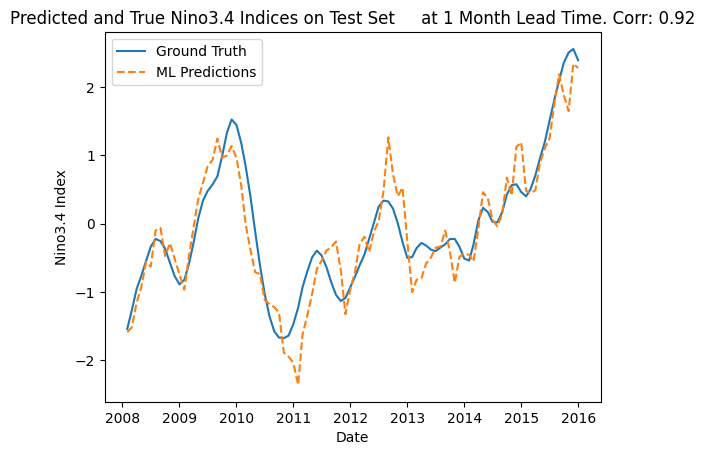

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                1)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


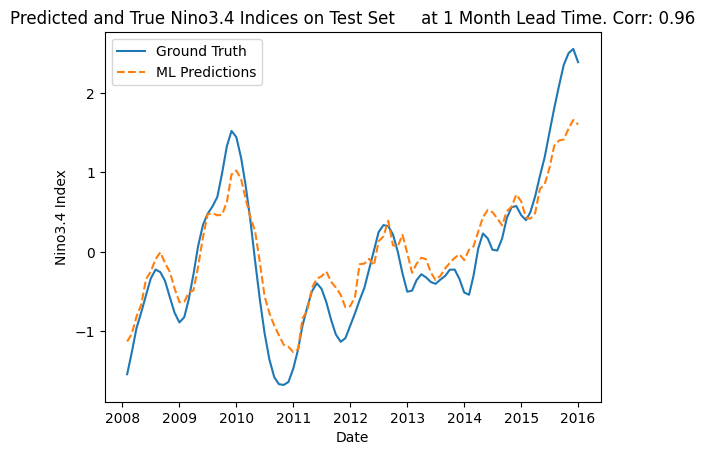

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',1)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


On the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

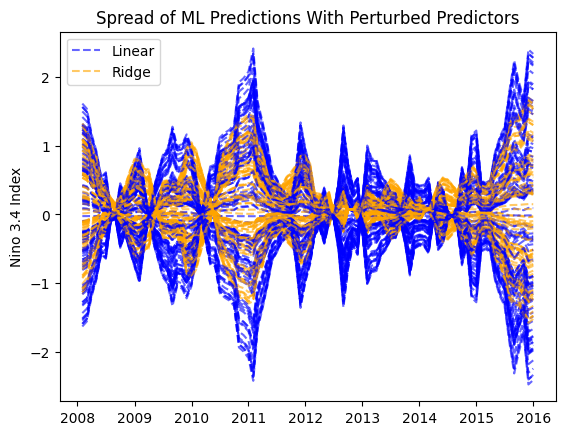

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
# you can change the number of iterations.
for experiment_num in range(100):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)
  
  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the CCAI tutorial, you can find an illustration of how ridge regression help to reduce sensitivity to samples.

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting

# Physical Interpretability

One important aspect of machine learning in climate science is physical interpretability!  We want to understand what our model is doing under the hood as well as possible.  Why is the model making its predictions?  What information is it using to make them.  In linear regression, one way to interpret the model is to visualize the learned regression weights.

In the code cells below, we train a linear regression model to predict ENSO, and then we visualize the learned regression weights.

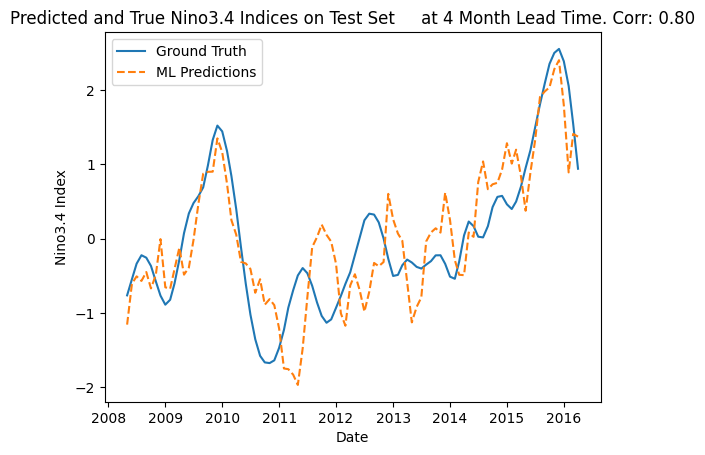

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                4)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 4,
                                                  )
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 4 Month Lead Time. Corr: {:.2f}'.format(corr))


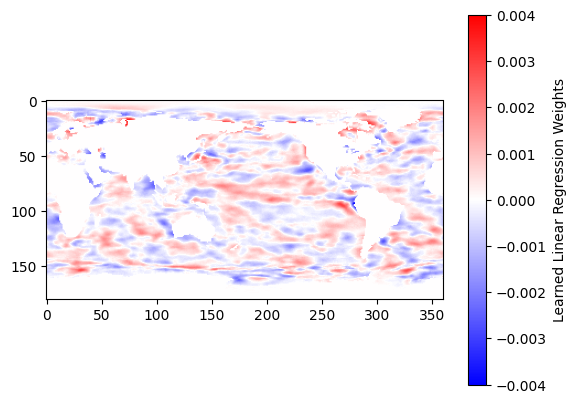

In [ ]:
#The weights have shape (64800,) because the 2D (lat x lon) field
#has been flattened into a 1D vector in order to perform linear regression
#To visualize the weights, we set them back into (lat x lon) field
#to see the spatial distribution of the weights
regr_1_month_lr_weights = regr_1_month_lr.coef_.reshape((180,360))

plt.imshow(regr_1_month_lr_weights, cmap='bwr', vmin=-0.004, vmax=0.004)
cb = plt.colorbar()
cb.set_label("Learned Linear Regression Weights")

 See this paper from [Mamalakis et. al](https://arxiv.org/ftp/arxiv/papers/2103/2103.10005.pdf). for an overview and comparison of different physical interpretability methods that could be used in an ML for climate science problem.

How do the physical interpretability methods compare to visualizing the linear regression weights?  Why might this be the case?

**Take-home exercise III:** What data sources improve the ML algorithm? What data sources do not improve the ML algorithm?

Let's try training our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset.  There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

Please generate two plots: one showing the time series of predicted and true Niño3.4 indices with an ML model trained on 1900-1930 data.  The other should show the same (time series of prediced and true Niño3.4 indices with a model trained on 1975-2005 data.  (Both trained algorithms should be tested on data from 2007-2018.)

In [ ]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
  """YOUR CODE HERE"""
  #Replicate the logic in the "linear regression" to explore 
  #how well the model does with the start 
  #and end dates defined above!  Plot the performance of the models!

# Additional Reading Material After This Tutorial

To supplement this tutorial, I have included topics on traditional machine learning that I think are crucial for all ML practitioners in climate science to know.  

1. What is boosting? Why is it necessary and how does it help? (Prof. Shewchuk pg. 147, Nasiriany pg. 169) 

2. How do traditional ML models work? Logistic regression (Nasiriany pg. 113), random forests (Nasiriany pg. 163), and support vector machines (Nasiriany pg. 127)

3. What strategies help alleviate challenges of data being linearly inseparable? (Professor Shewchuk pg. 20) What is the kernel trick? How does it help with this challenge? (Prof. Shewchuk pg. 76)

4. Gradient Descent and Newton's method (Nasiriany pg. 82 and 93)